# Import libraries

In [1]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    KFold
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import (
    RobustScaler, 
    OneHotEncoder
)
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    VotingRegressor
)
from sklearn.feature_selection import RFE
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error
from boruta import BorutaPy
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

# Configuration

In [2]:
COL_NAMES = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Whole weight.1",
    "Whole weight.2",
    "Shell weight",
    "Rings",
]

NUMERICAL_COLS = [
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Whole weight.1",
    "Whole weight.2",
    "Shell weight",
]

CATEGORICAL_COL = ["Sex"]
SEED = 42

fold = KFold(n_splits=10, shuffle=True, random_state=SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Functions

In [86]:
def add_features(df):
    df['length_diameter_ratio'] = df['Length'] / df['Diameter']
    df['height_length_ratio'] = df['Height'] / df['Length']
    df['shell_to_whole_weight_ratio'] = df['Shell weight'] / df['Whole weight']

    df['non_shell_weight'] = df['Whole weight'] - df['Shell weight']

    df['diff_length_diameter'] = df['Length'] - df['Diameter']
    df['diff_whole_whole1'] = df['Whole weight'] - df['Whole weight.1']
    df['diff_whole_whole2'] = df['Whole weight'] - df['Whole weight.2']
    
    df['length_diameter'] = df['Length'] * df['Diameter']
    df['whole_weight_shell_weight'] = df['Whole weight'] * df['Shell weight']
    df['whole_weight_whole_weight1'] = df['Whole weight'] * df['Whole weight.1']
    df['whole_weight_whole_weight2'] = df['Whole weight'] * df['Whole weight.2']

    df['total_weight'] = df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2'] + df['Shell weight']
    df['total_whole_weight'] = df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2']

    #df['bmi'] = df['total_weight'] / df['Height'] ** 2
    return df

# Import data

In [4]:
# Train data from Kaggle
org_train = pd.read_csv('data/train.csv')

# Orginal data from UCI
org_data = pd.read_csv('data/abalone.data', header=None, names=COL_NAMES)

In [5]:
# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df_master = pd.concat([org_train, org_data])

# Leave the original data as is
df = df_master.copy()
df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# EDA

In [6]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df_master.shape}, {df.shape}')

Before concat: (90615, 9), (4177, 9)

After concat: (94792, 9), (94792, 9)


In [7]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


> Comment: Columns seem to be in the right type.

## Null & Duplicates analysis

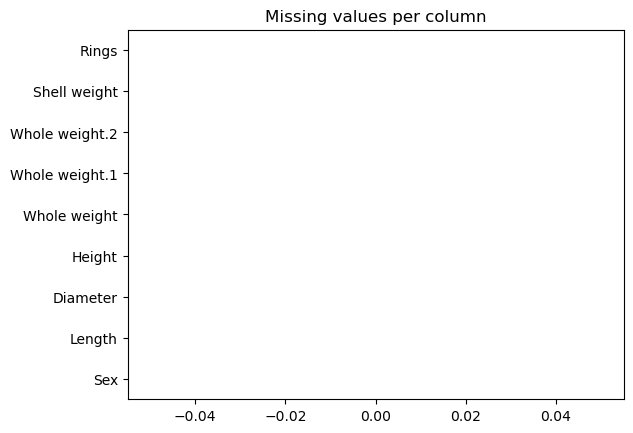

In [8]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [9]:
# Check for duplication
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


> Comment: Good new that there's no nulls or duplicated records in the train set.

## Categorical variables

In [10]:
# Select only categorical
categorical_columns = list(df.select_dtypes(include=['object']))
categorical_columns

['Sex']

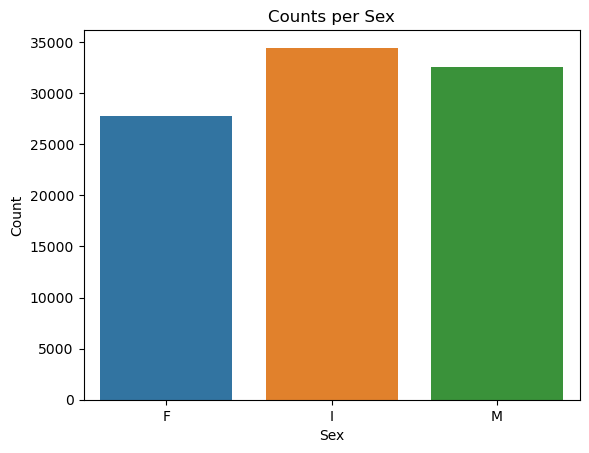

In [11]:
sns.countplot(data=df, x="Sex")
plt.title("Counts per Sex")
plt.ylabel("Count")
plt.show()

## Numerical variables

In [12]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float64', 'int64']))
numerical_columns

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

In [13]:
# Check statistics
df[numerical_columns].describe().round(3)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000
mean,0.517,0.402,0.136,0.791,0.342,0.170,0.226,9.707
std,0.118,0.098,0.038,0.459,0.205,0.101,0.131,3.179
min,0.075,0.055,0.000,0.002,0.001,0.000,0.002,1.000
25%,0.445,0.345,0.110,0.420,0.178,0.086,0.120,8.000
50%,0.545,0.425,0.140,0.800,0.330,0.166,0.225,9.000
75%,0.600,0.470,0.160,1.072,0.464,0.233,0.305,11.000
max,0.815,0.650,1.130,2.826,1.488,0.760,1.005,29.000


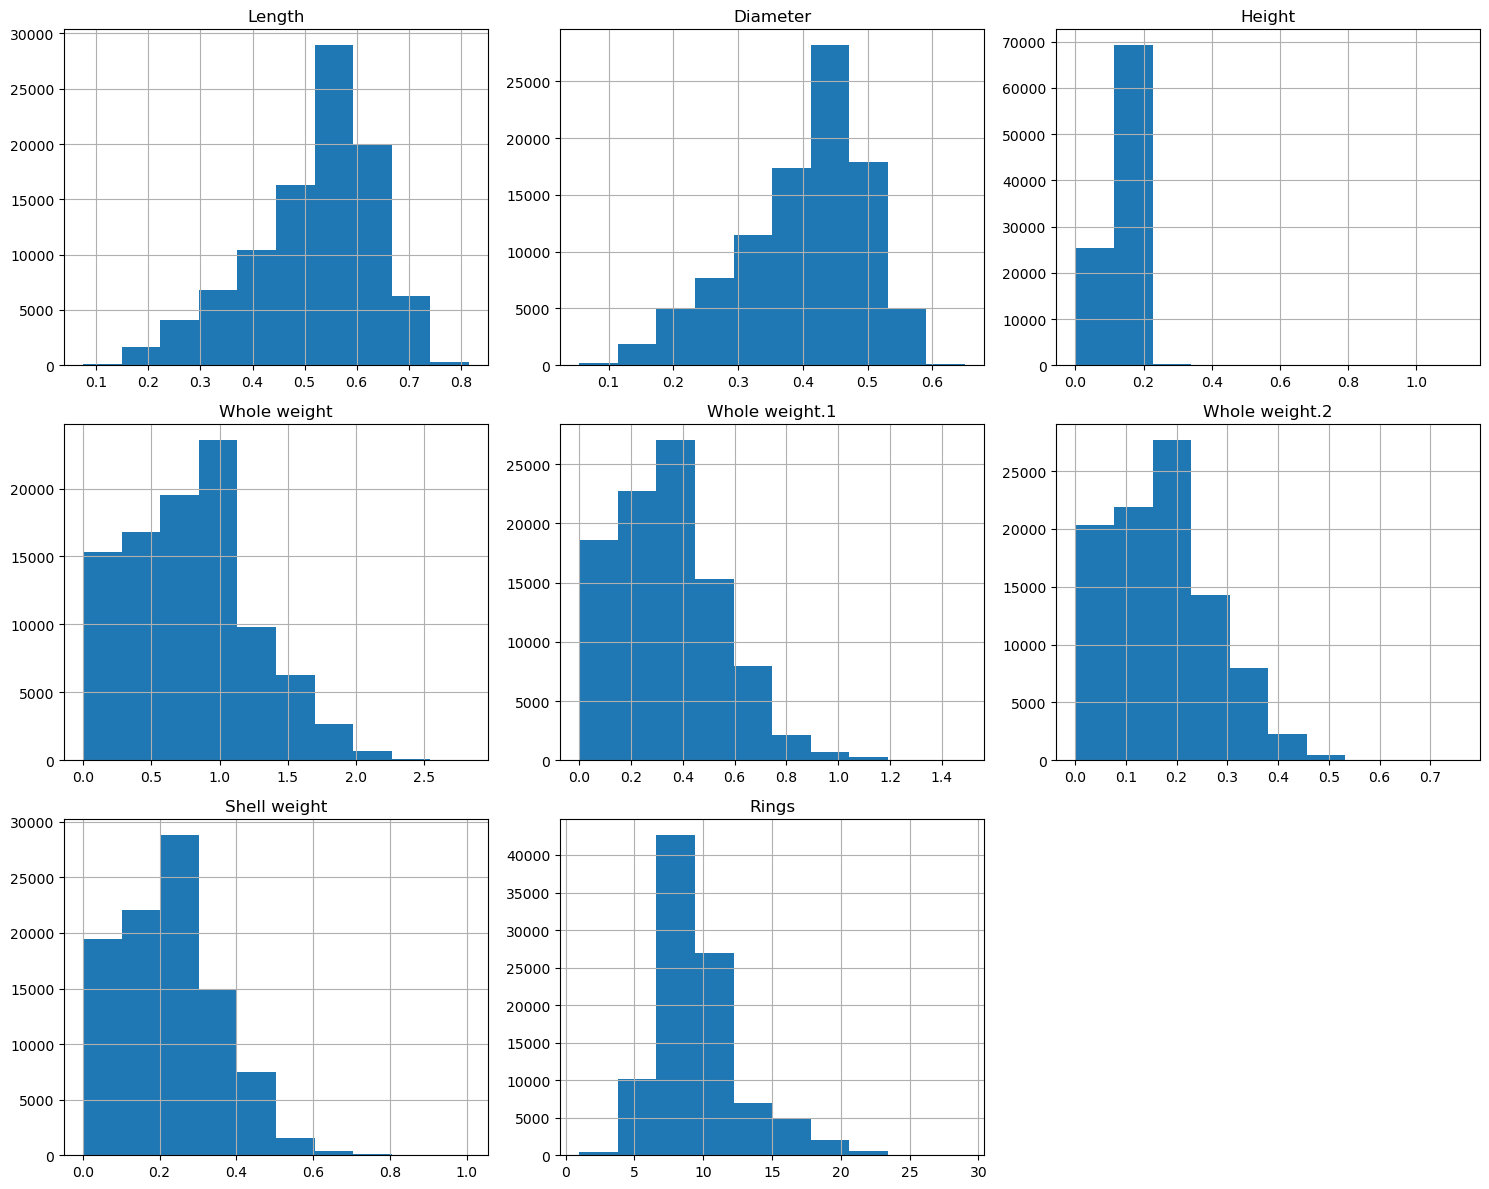

In [14]:
df.hist(figsize=(15, 12))
plt.title("Numerical features distribution with Histograms")
plt.tight_layout()
plt.show()

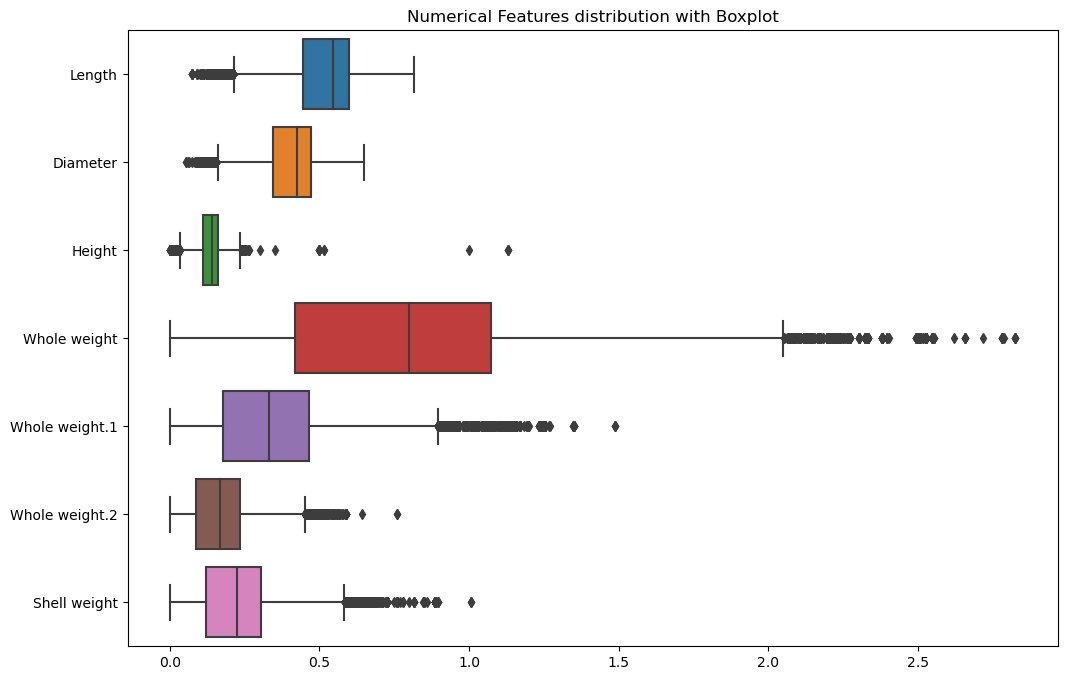

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[NUMERICAL_COLS], orient='h')
plt.title('Numerical Features distribution with Boxplot')
plt.show()

> Comment: **Length** and **Diameter** are almost symmetrical while the others are not, needs transformation.

In [16]:
skew_coefficients = df[numerical_columns].skew()
skew_coefficients

Length           -0.727373
Diameter         -0.690925
Height            0.475841
Whole weight      0.436328
Whole weight.1    0.601075
Whole weight.2    0.485542
Shell weight      0.488303
Rings             1.200004
dtype: float64

> Comment: Checking the skew coefficients, we can see most features are moderately skewed.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

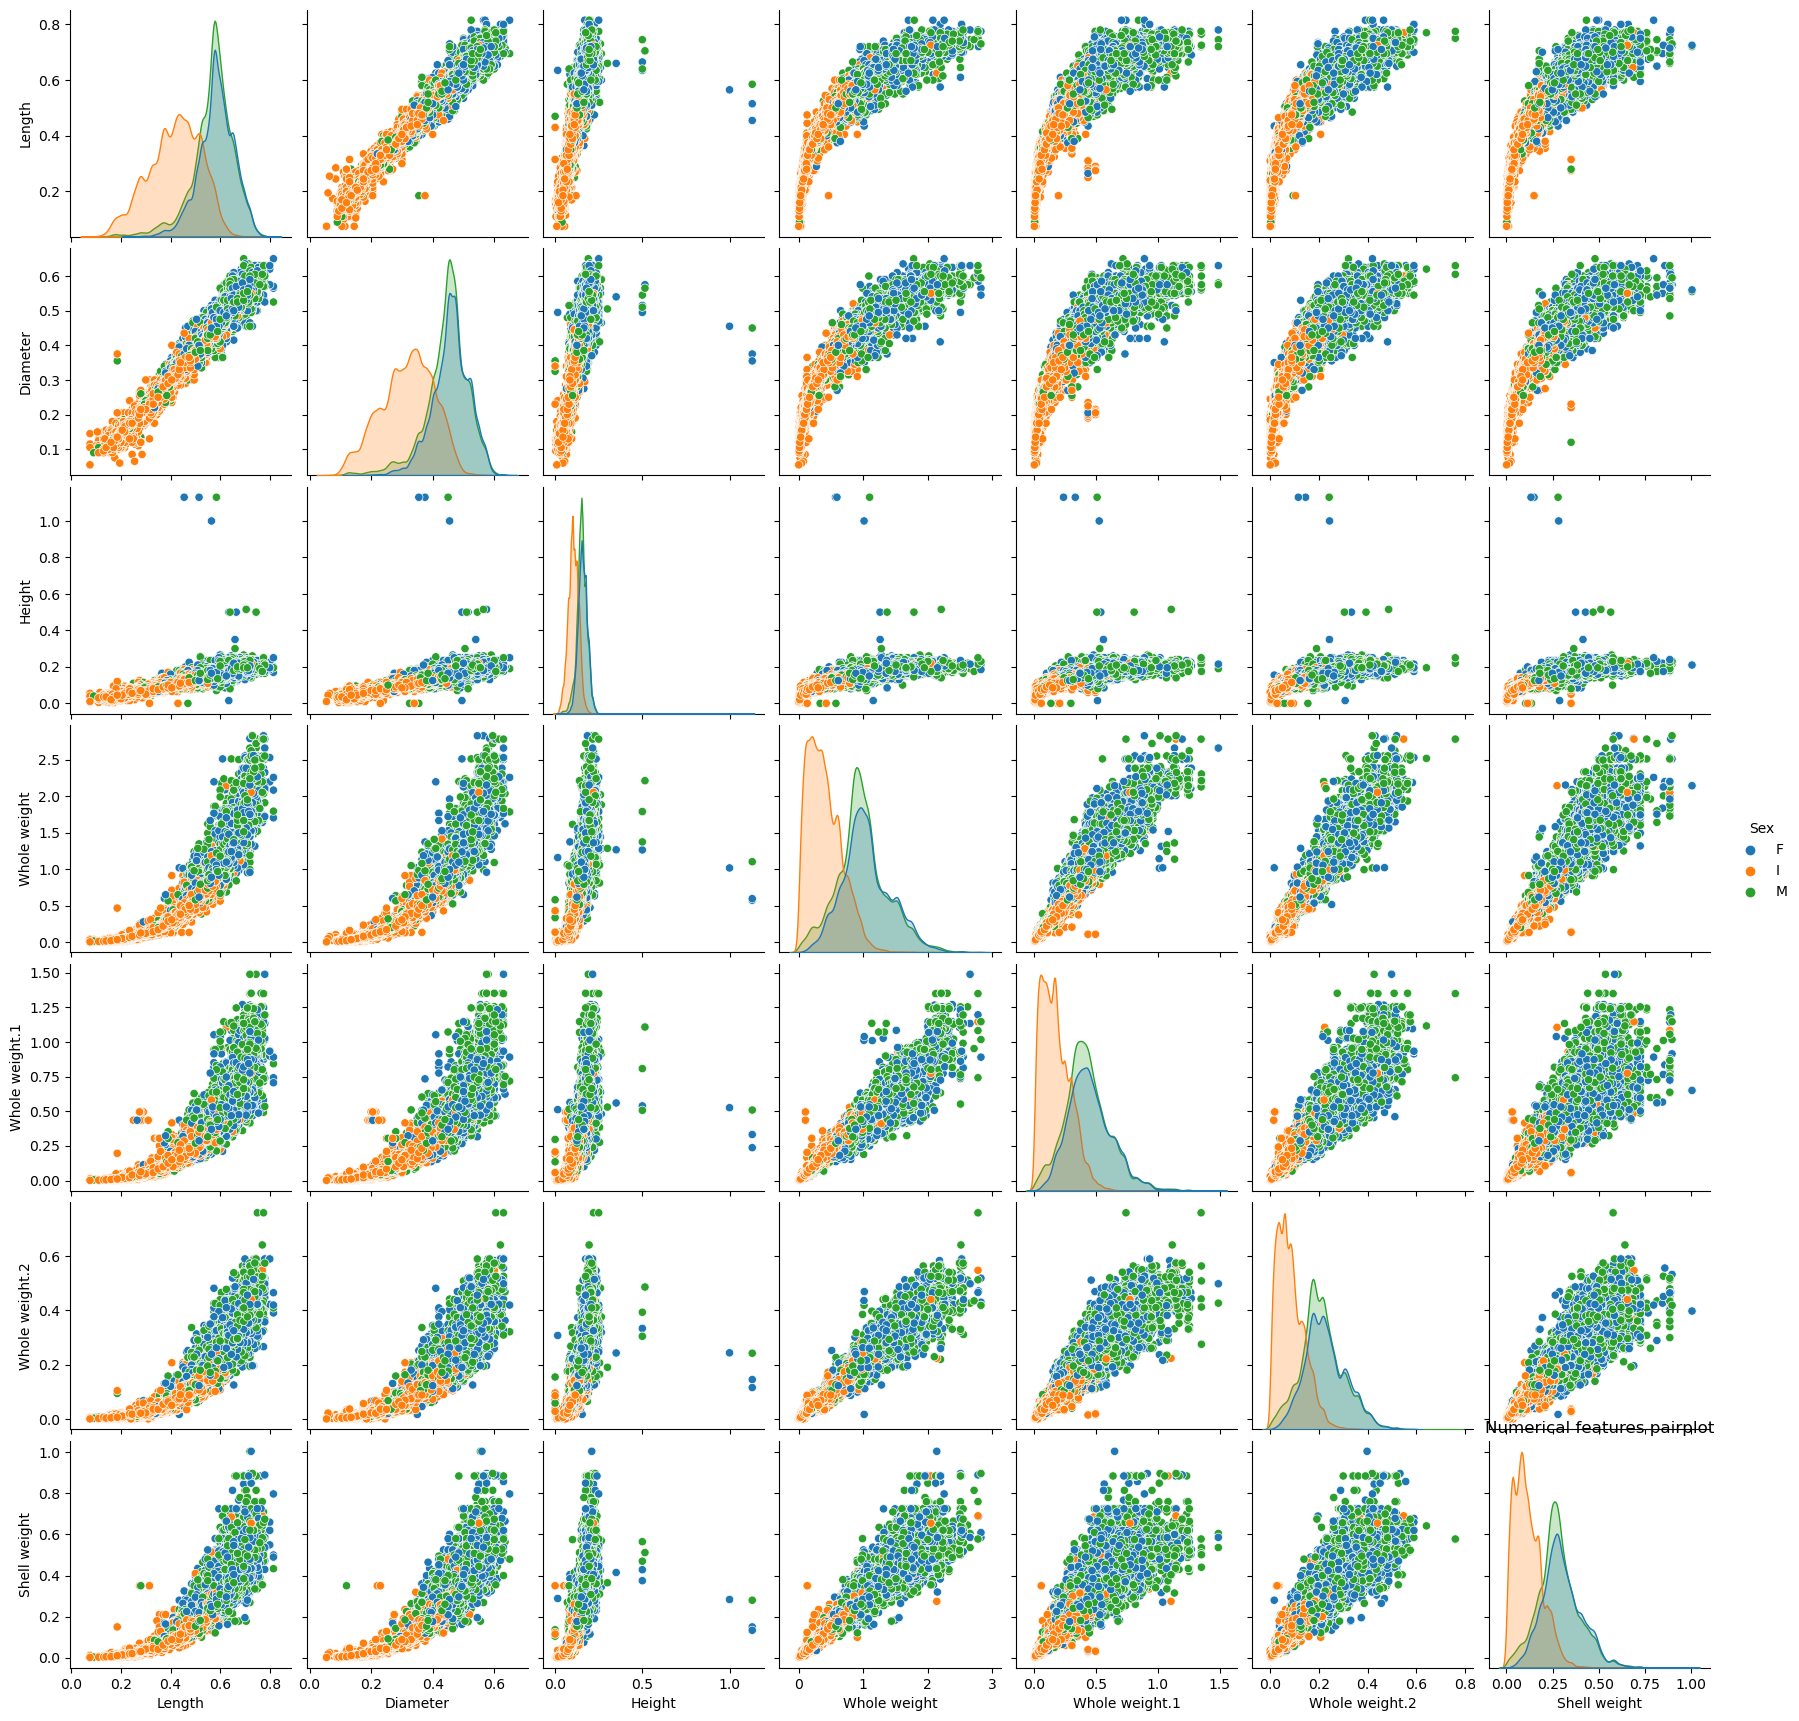

In [17]:
sns.pairplot(data=df, vars=NUMERICAL_COLS, hue="Sex")
plt.title("Numerical features pairplot")
plt.show()

## Target variable

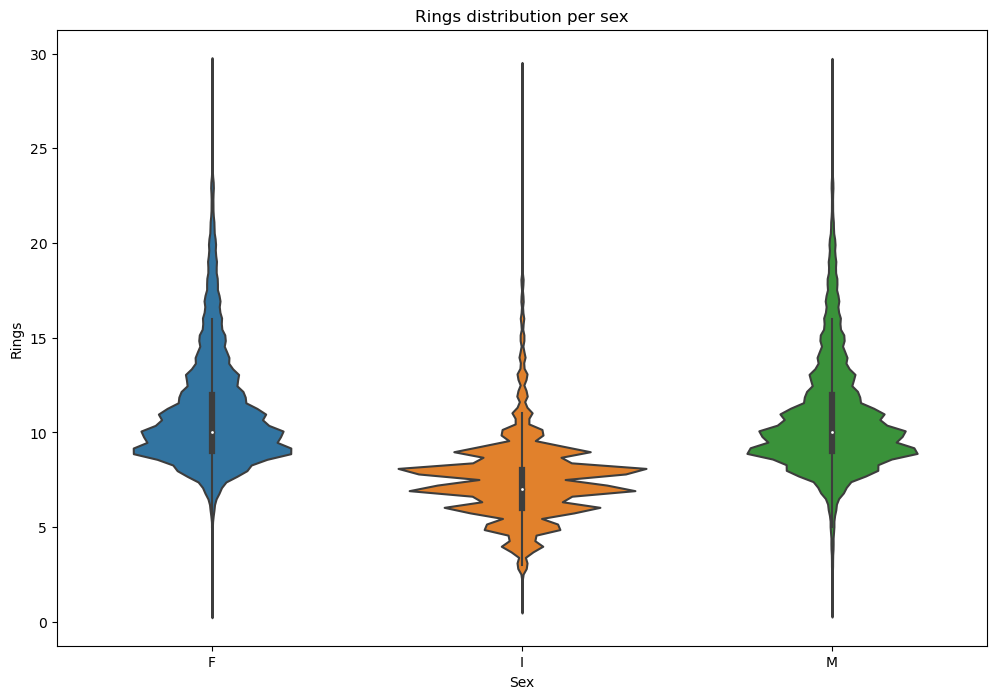

In [18]:
plt.subplots(figsize=(12, 8))
sns.violinplot(data=df, y="Rings", x="Sex")
plt.title("Rings distribution per sex")
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


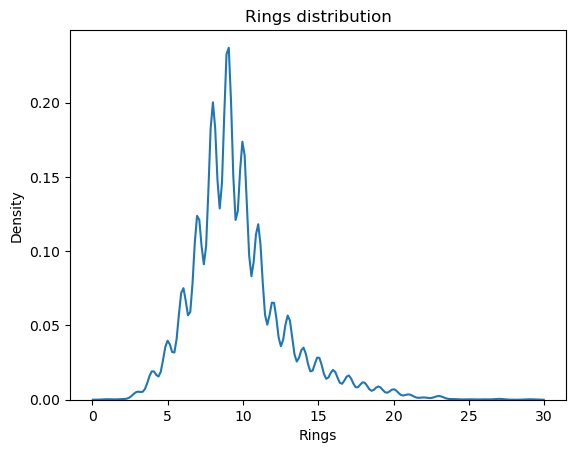

In [19]:
sns.kdeplot(data=df, x="Rings")
plt.title("Rings distribution")
plt.show()

> Comment: It would be interesting to transform the target to see the performance differences.

## Correlation

In [20]:
# Create copy for correlation calculation
correlation_df = df.copy()

# Convert to use corr function
correlation_df.Sex = correlation_df.Sex.astype('category').cat.codes

# Create no target correlation matrix dataframe
no_target_df = correlation_df.drop('Rings', axis=1)

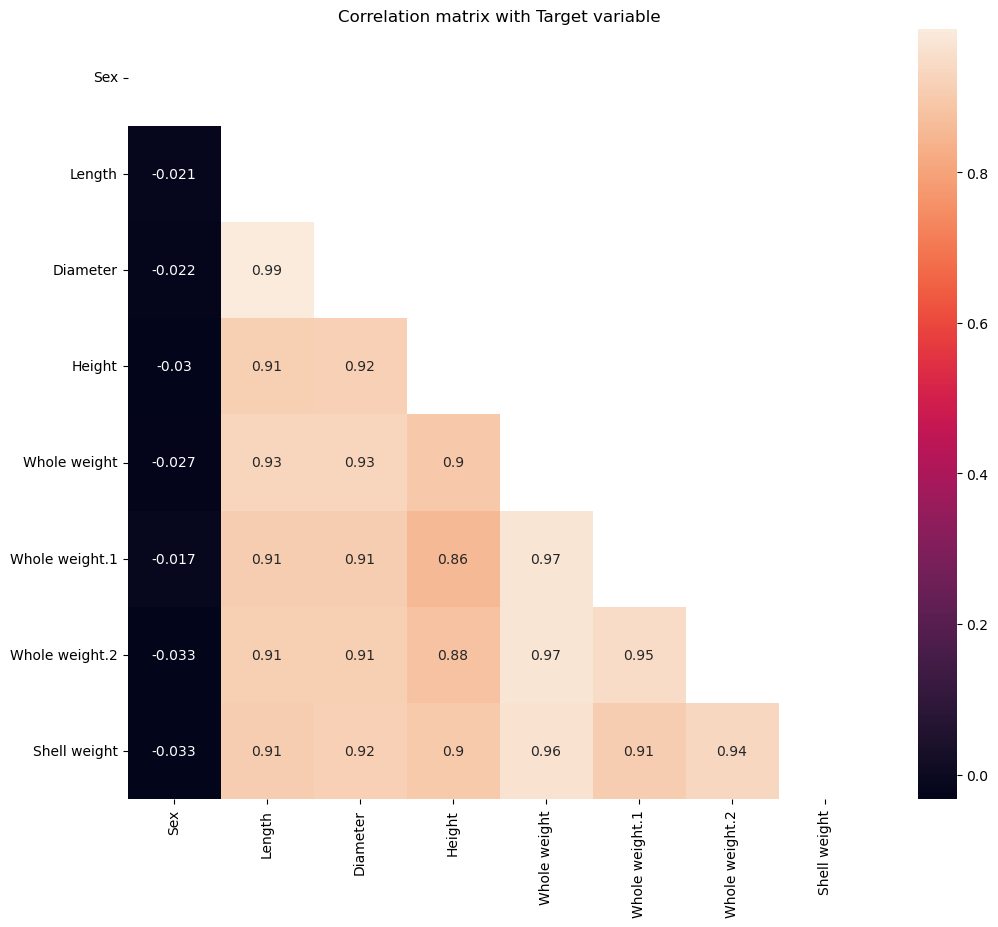

In [21]:
without_target_corr_matrix = no_target_df.corr() # Default is Pearson

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(without_target_corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(without_target_corr_matrix.round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix with Target variable")
plt.show()

In [22]:
# Calculate the correlation matrix with target
correlation_df.corr().abs()["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.691610
Height            0.660468
Diameter          0.634092
Length            0.620809
Whole weight      0.613666
Whole weight.2    0.584903
Whole weight.1    0.510597
Sex               0.026677
Name: Rings, dtype: float64

# Pre-processing

In [87]:
features = df.drop('Rings', axis=1)
target = df['Rings']

In [88]:
new_features = add_features(features)

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(
    new_features, target, test_size=0.2, random_state=SEED, shuffle=True, stratify=target,
)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (75833, 8), (75833,)
Test data shape: (18959, 8), (18959,)


# Feature engineering

In [25]:
processor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS),
        ('cat', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COL)
    ], remainder='passthrough'
)

In [26]:
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

# Get the column names from the processor object
column_names = processor.get_feature_names_out(input_features=X_train.columns)

In [89]:
numerics_cols = list(X_train_nf.select_dtypes(include=['float64', 'int64']).columns)

nf_processor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerics_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COL)
    ], remainder='passthrough'
)

X_train_nf_processed = nf_processor.fit_transform(X_train_nf)
X_test_nf_processed = nf_processor.transform(X_test_nf)

# Metric

The evaluation metric for this competition is the Root Mean Squared Logarithmic Error (RMSLE). 

The RMSLE is calculated as follows:

$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\log(1+\hat{y}_i) - \log(1+y_i)\right)^2}$$

Where:
- $n \text{ is the total number of observations in the test set.}$
- $\hat{y}_i \text{ is the predicted value of the target for instance } i.$
- $y_i \text{ is the actual value of the target for instance } i.$
- $\log \text{ denotes the natural logarithm.}$

# Modeling

In [90]:
# Create regressors
xgb_reg = XGBRegressor(n_jobs=-1, random_state=SEED)
catboost_reg = CatBoostRegressor(random_state=SEED, verbose=False)
lgbm_reg = LGBMRegressor(random_state=SEED, n_jobs=-1, verbose=-1)

## All original features

In [28]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with all features: {round(end_time - start_time, 2)} seconds")



Execution time with all features: 69.08 seconds


In [29]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
all_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
all_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.867
LightGBM,1.858
CatBoost,1.843


100%|===================| 18957/18959 [12:40<00:00]        

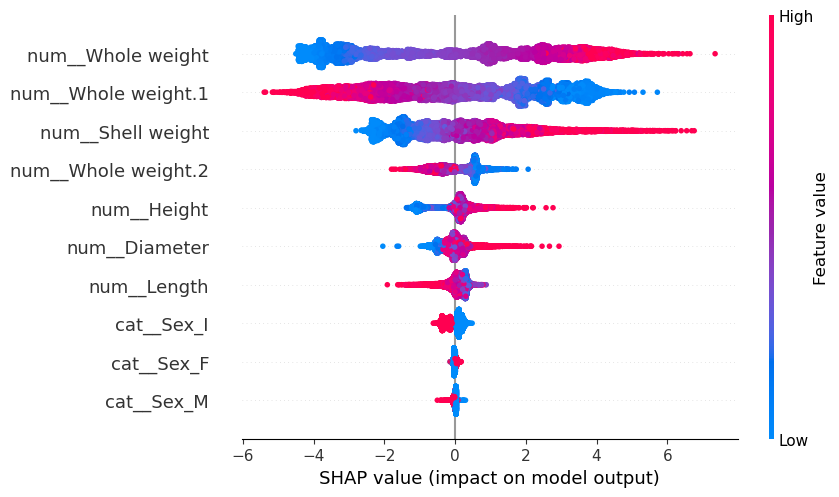

In [30]:
catboost_reg.fit(X_train_processed, y_train)
explainer = shap.Explainer(catboost_reg, X_test_processed, feature_names=column_names)
cat_shap_values = explainer(X_test_processed)
shap.plots.beeswarm(cat_shap_values)

### Feature set using Information gain Feature selection

In [31]:
# Calculate gains
features_info_gain = mutual_info_classif(X_train_processed, y_train, random_state=SEED)

# Display information gain as a dataframe
info_gain_df = pd.DataFrame(features_info_gain, index=column_names, columns=['Information_Gain'])
info_gain_df.sort_values(by='Information_Gain', ascending=False, inplace=True)
info_gain_df

,Information_Gain
num__Shell weight,0.667512
num__Whole weight,0.569786
num__Height,0.543387
num__Diameter,0.535067
num__Whole weight.2,0.532627
num__Length,0.525005
num__Whole weight.1,0.499962
cat__Sex_I,0.232583
cat__Sex_F,0.074942
cat__Sex_M,0.060860


In [32]:
# Drop the least important feature
info_gain_features = features.drop("Sex", axis=1)

X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(info_gain_features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True)

# Create a new processor
processor_ig = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS)
    ], remainder='passthrough'
)

# Transform
X_train_ig_processed = processor_ig.fit_transform(X_train_ig)
X_test_ig_processed = processor_ig.transform(X_test_ig)

In [33]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with Information gain features: {round(end_time - start_time, 2)} seconds")



Execution time with Information gain features: 69.67 seconds


In [34]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
info_gain_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
info_gain_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.878
LightGBM,1.866
CatBoost,1.853


### Feature set using Recursive feature elimination selection

In [35]:
# Base estimator for RFE
gb = GradientBoostingRegressor(random_state=SEED)

rmse_scores_list = []

# Loop to find the best number of features
for k in range(1, X_train_processed.shape[1] + 1):
    rfe = RFE(estimator=gb, n_features_to_select=k, step=1)
    rfe.fit(X_train_processed, y_train)

    X_train_rfe = rfe.transform(X_train_processed)
    X_test_rfe = rfe.transform(X_test_processed)

    gb.fit(X_train_rfe, y_train)
    rfe_pred = gb.predict(X_test_rfe)

    rsme = root_mean_squared_log_error(y_test, rfe_pred)
    rmse_scores_list.append(rsme)

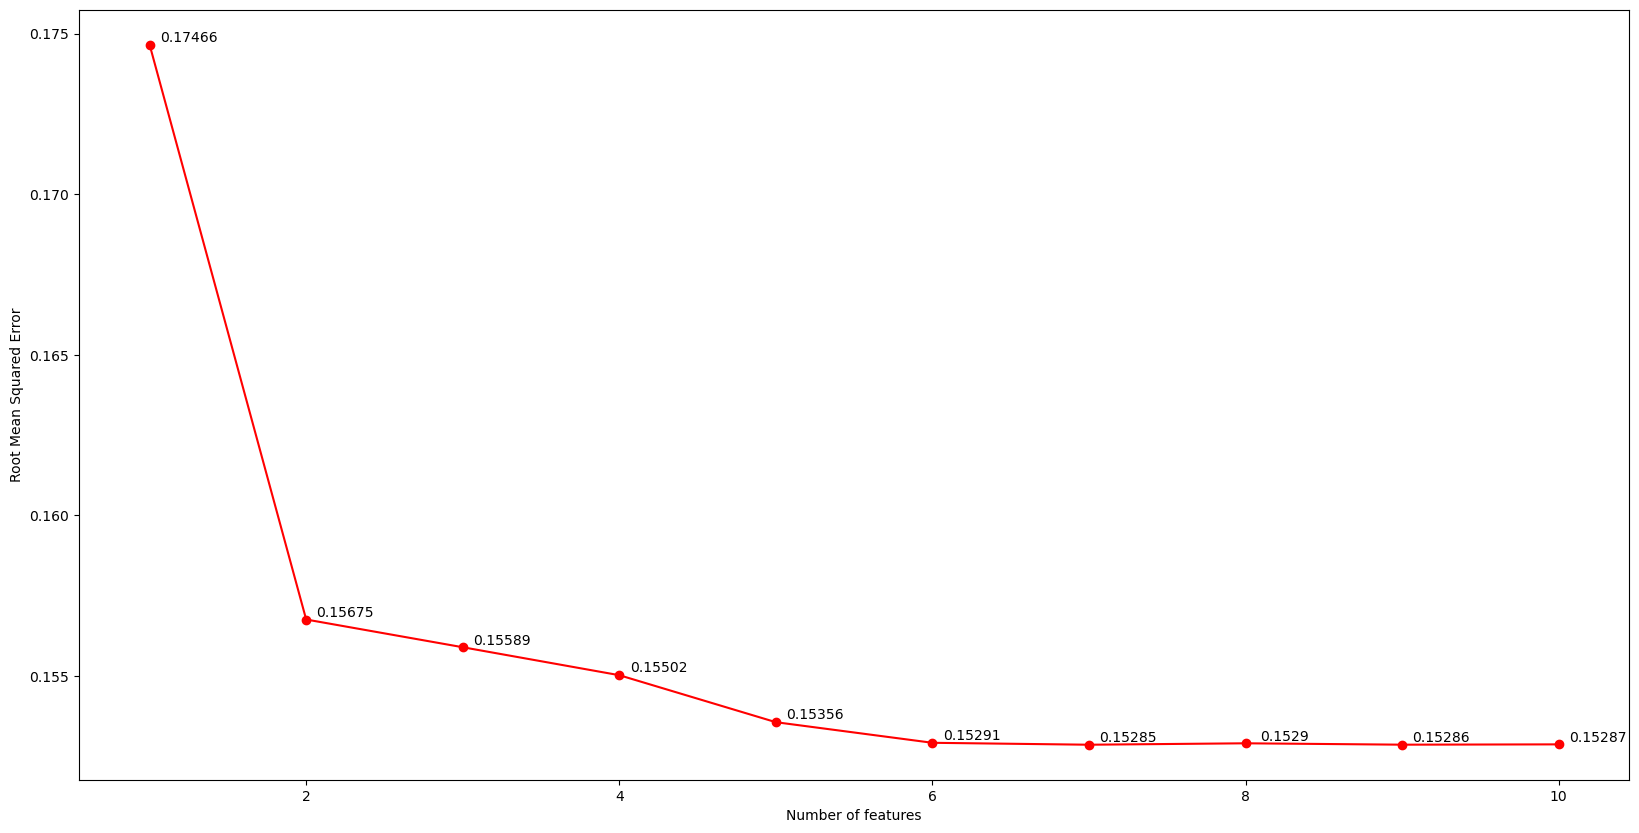

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the number of features
no_features = np.arange(1, X_train_processed.shape[1] + 1)

ax.plot(no_features, rmse_scores_list, marker='o', color='r')
plt.xlabel("Number of features")
plt.ylabel("Root Mean Squared Error")

for i, v in enumerate(rmse_scores_list):
    ax.text(i+1.25, v, round(v, 5), ha='center', va='bottom')
    
plt.show()

In [37]:
rfe_selector = RFE(estimator=gb, n_features_to_select=7, step=10)
rfe_selector.fit(X_train_processed, y_train)

selected_feats_array = rfe_selector.get_support()
selected_features = processor.get_feature_names_out()[selected_feats_array]

print("Selected Features:", selected_features)

Selected Features: ['num__Length' 'num__Height' 'num__Whole weight' 'num__Whole weight.1'
 'num__Whole weight.2' 'num__Shell weight' 'cat__Sex_I']


In [38]:
# Only selected features
X_train_selected = X_train_processed[:, selected_feats_array]

# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with RFE features: {round(end_time - start_time, 2)} seconds")



Execution time with RFE features: 64.91 seconds


In [39]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
rfe_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
rfe_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.870
LightGBM,1.858
CatBoost,1.846


### Feature set using Boruta selection

In [35]:
""" Error to be fixed
boruta = BorutaPy(
   estimator = gb, # Reuse the GradientBoostingRegressor 
   n_estimators = 'auto',
   max_iter = 100, # number of trials to perform
   random_state=SEED
)

boruta.fit(X_train_processed, y_train.values.ravel())

# Get the selected features
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()

print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
"""

" Error to be fixed\nboruta = BorutaPy(\n   estimator = gb, # Reuse the GradientBoostingRegressor \n   n_estimators = 'auto',\n   max_iter = 100, # number of trials to perform\n   random_state=SEED\n)\n\nboruta.fit(X_train_processed, y_train.values.ravel())\n\n# Get the selected features\ngreen_area = X_train.columns[boruta.support_].to_list()\nblue_area = X_train.columns[boruta.support_weak_].to_list()\n\nprint('features in the green area:', green_area)\nprint('features in the blue area:', blue_area)\n"

### Optuna

#### CatBoost

In [42]:
def objective_cat(trial):
    param = {
        "iterations": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = CatBoostRegressor(**param, verbose=False, random_state=SEED)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_cat = optuna.create_study(direction='maximize', study_name='Cat Boosting')
study_cat.optimize(objective_cat, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_cat.trials)}")
print("Best trial:")
trial = study_cat.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.9161582697007695
  Params: 
    n_estimators: 976
    learning_rate: 0.06406711422382977
    colsample_bylevel: 0.09523742454585887
    min_data_in_leaf: 11
    depth: 12
    l2_leaf_reg: 3.137199809579245e-05
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.261835427471923



In [43]:
plot_optimization_history(study_cat)

In [44]:
plot_param_importances(study_cat)

In [45]:
plot_slice(study_cat)

In [46]:
def objective_cat(trial):
    param = {
        "iterations": trial.suggest_int("n_estimators", 100, 5000), # 3rd
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True), # Most important
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.001, 0.1, log=True), # 2nd
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 100, log=True), # Smaller scale
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"] # Remove one
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.05, 1, log=True)

    model = CatBoostRegressor(**param, verbose=False, random_state=SEED)

    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_mean = np.mean(cv_scores)

    # Report the intermediate result to Optuna
    trial.report(cv_mean, step=1)

    # Prune the trial if the intermediate result is not promising
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_mean


study_cat = optuna.create_study(direction='maximize', study_name='Cat Boosting 2')
study_cat.optimize(objective_cat, n_trials=100, n_jobs=-1, show_progress_bar=True)

cat_best_params = study_cat.best_params
cat_best_value = study_cat.best_value
trial = study_cat.best_trial

print(f"\n\nNumber of finished trials: {len(study_cat.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.86743417558757
  Params: 
    n_estimators: 4471
    learning_rate: 0.05353229928706592
    colsample_bylevel: 0.09823718511218636
    min_data_in_leaf: 25
    depth: 10
    l2_leaf_reg: 0.00017499779597132534
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.34657662938626815



#### LightGBM

In [47]:
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        "num_leaves": trial.suggest_int('num_leaves', 2, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 16),
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0, 15),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.5, 1),
        "baggging_freq": trial.suggest_int('baggging_freq', 1, 10),
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 1),
        "lambda_l1": trial.suggest_float('lambda_l1', 1e-8, 100),
        "lambda_l2": trial.suggest_float('lambda_l2', 1e-8, 100),
    }

    model = LGBMRegressor(**params, verbose=-1, random_state=SEED)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_lgbm.trials)}")
print("Best trial:")
trial = study_lgbm.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8402912713420068
  Params: 
    n_estimators: 393
    max_depth: 20
    learning_rate: 0.0403792329270483
    boosting_type: gbdt
    num_leaves: 184
    min_child_samples: 61
    min_data_in_leaf: 8
    min_gain_to_split: 0.8468126363325172
    bagging_fraction: 0.980213295648199
    baggging_freq: 3
    feature_fraction: 0.6738610907540479
    lambda_l1: 46.68241202031515
    lambda_l2: 47.35044599423721



In [48]:
plot_optimization_history(study_lgbm)

In [49]:
plot_param_importances(study_lgbm)

In [50]:
plot_slice(study_lgbm)

In [51]:
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 1, 1000), # Most important
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True), # 2nd
        "boosting_type": 'gbdt', # Remove dart
        "num_leaves": trial.suggest_int('num_leaves', 2, 180), # Descrease the range
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 100), # Descrease the range
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 5, 20), # Increase the range
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0, 30), # 3rd
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.1, 0.8), 
        "baggging_freq": trial.suggest_int('baggging_freq', 1, 7), # Decrease the range
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 0.8),
        "lambda_l1": trial.suggest_float('lambda_l1', 1e-8, 50), # Smaller scale
        "lambda_l2": trial.suggest_float('lambda_l2', 1e-8, 50), # Smaller scale
    }

    model = LGBMRegressor(**params, verbose=-1, random_state=SEED)

    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_mean = np.mean(cv_scores)

    # Report the intermediate result to Optuna
    trial.report(cv_mean, step=1)

    # Prune the trial if the intermediate result is not promising
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_mean


study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

lgbm_best_params = study_lgbm.best_params
lgbm_best_value = study_lgbm.best_value
trial = study_lgbm.best_trial

print(f"\n\nNumber of finished trials: {len(study_lgbm.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.834949040248409
  Params: 
    n_estimators: 1275
    max_depth: 681
    learning_rate: 0.05156232197784499
    num_leaves: 96
    min_child_samples: 56
    min_data_in_leaf: 14
    min_gain_to_split: 0.13142421926577552
    bagging_fraction: 0.22559453510720684
    baggging_freq: 2
    feature_fraction: 0.5806722628836526
    lambda_l1: 33.24198788638861
    lambda_l2: 10.84479917883586



#### XGBoost

In [52]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1, log=True),
    }

    model = XGBRegressor(**params, random_state=SEED, tree_method="hist", objective="reg:squaredlogerror", eval_metric="rmsle", n_jobs=8)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_xgb.trials)}")
print("Best trial:")
trial = study_xgb.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8506383181553794
  Params: 
    n_estimators: 817
    learning_rate: 0.10936227220170655
    max_depth: 5
    min_child_weight: 1.0538570513571313
    subsample: 0.9596201768276065
    colsample_bytree: 0.8386239514662036
    gamma: 3.1952258921573704e-05



In [53]:
plot_optimization_history(study_xgb)

In [54]:
plot_param_importances(study_xgb)

In [55]:
plot_slice(study_xgb)

In [56]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 10000), #  Increase the range
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True), # Most important
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'gamma': trial.suggest_float('gamma', 0.0001, 10, log=True),
    }

    model = XGBRegressor(**params, random_state=SEED, tree_method="hist", objective="reg:squaredlogerror", eval_metric="rmsle", n_jobs=-1)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, show_progress_bar=True)

xgb_best_params = study_xgb.best_params
xgb_best_value = study_xgb.best_value
trial = study_xgb.best_trial

print(f"\n\nNumber of finished trials: {len(study_xgb.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/raydi/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.





Number of finished trials: 100
Best trial:
  Value: -1.8478908305965909
  Params: 
    n_estimators: 9054
    learning_rate: 0.020882197540007044
    max_depth: 20
    min_child_weight: 0.4077087754942985
    subsample: 0.7371734378514421
    colsample_bytree: 0.9500884880471744
    gamma: 0.038249077439328476



### Voting

In [57]:
# Cat best params
# {'n_estimators': 3257, 'learning_rate': 0.09731247786807815, 'colsample_bylevel': 0.09621871163263937, 'min_data_in_leaf': 10, 'depth': 12, 'l2_leaf_reg': 9.227164397396603, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12007885613333591}

# LGBM best params
# {'n_estimators': 1864, 'max_depth': 144, 'learning_rate': 0.020689368759177377, 'num_leaves': 158, 'min_child_samples': 61, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.608706452025638, 'bagging_fraction': 0.6604277008873509, 'baggging_freq': 2, 'feature_fraction': 0.6484463071560206, 'lambda_l1': 6.096374383431147, 'lambda_l2': 4.8218929887931035}

# XGB best params
# {'n_estimators': 5771, 'learning_rate': 0.03488445577258532, 'max_depth': 20, 'min_child_weight': 0.131573564420784, 'subsample': 0.5987733939001006, 'colsample_bytree': 0.7601417859716126, 'gamma': 0.04547919768940751}

In [58]:
voting = [
    (
        "LightGBM",
        LGBMRegressor(
            **{
                "n_estimators": 1864,
                "max_depth": 144,
                "learning_rate": 0.020689368759177377,
                "num_leaves": 158,
                "min_child_samples": 61,
                "min_data_in_leaf": 10,
                "min_gain_to_split": 0.608706452025638,
                "bagging_fraction": 0.6604277008873509,
                "baggging_freq": 2,
                "feature_fraction": 0.6484463071560206,
                "lambda_l1": 6.096374383431147,
                "lambda_l2": 4.8218929887931035,
            },
            random_state=SEED,
            n_jobs=-1,
            verbose=-1
        ),
    ),
    (
        "CatBoost",
        CatBoostRegressor(
            **{
                "n_estimators": 3257,
                "learning_rate": 0.09731247786807815,
                "colsample_bylevel": 0.09621871163263937,
                "min_data_in_leaf": 10,
                "depth": 12,
                "l2_leaf_reg": 9.227164397396603,
                "boosting_type": "Ordered",
                "bootstrap_type": "Bayesian",
                "bagging_temperature": 0.12007885613333591,
            },
            random_state=SEED,
            verbose=False
        ),
    ),
    (
        "XGBoost",
        XGBRegressor(
            **{
                "n_estimators": 5771,
                "learning_rate": 0.03488445577258532,
                "max_depth": 20,
                "min_child_weight": 0.131573564420784,
                "subsample": 0.5987733939001006,
                "colsample_bytree": 0.7601417859716126,
                "gamma": 0.04547919768940751,
            },
            random_state=SEED,
            n_jobs=-1
        ),
    ),
]

ensemble_model = VotingRegressor(estimators=voting, n_jobs=-1)

In [59]:
print(f"Voting RMSLE: {np.mean(cross_val_score(ensemble_model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)) * -1}")

Voting RMSLE: 1.8419829415210862


### Target transformation

In [60]:
# y transformed regressors
ytrans_cat_model = CatBoostRegressor(**{'n_estimators': 3257, 'learning_rate': 0.09731247786807815, 'colsample_bylevel': 0.09621871163263937, 'min_data_in_leaf': 10, 'depth': 12, 'l2_leaf_reg': 9.227164397396603, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12007885613333591}, random_state=SEED, verbose=False)
ytrans_lgbm_model = LGBMRegressor(**{'n_estimators': 1864, 'max_depth': 144, 'learning_rate': 0.020689368759177377, 'num_leaves': 158, 'min_child_samples': 61, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.608706452025638, 'bagging_fraction': 0.6604277008873509, 'baggging_freq': 2, 'feature_fraction': 0.6484463071560206, 'lambda_l1': 6.096374383431147, 'lambda_l2': 4.8218929887931035}, random_state=SEED, n_jobs=-1, verbose=-1)
ytrans_xgb_model = XGBRegressor(random_state=SEED, n_jobs=-1)

# Transformed Target Regressors
cat_model = TransformedTargetRegressor(regressor=ytrans_cat_model, func=np.log1p, inverse_func=np.expm1)
lgbm_model = TransformedTargetRegressor(regressor=ytrans_lgbm_model, func=np.log1p, inverse_func=np.expm1)
xgb_model = TransformedTargetRegressor(regressor=ytrans_xgb_model, func=np.log1p, inverse_func=np.expm1)

In [61]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(cat_model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with Information gain features: {round(end_time - start_time, 2)} seconds")



Execution time with Information gain features: 67.97 seconds


In [62]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
transformed_y_rmsle_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
transformed_y_rmsle_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
LightGBM,1.924
CatBoost,1.876
XGB,1.868


## New features

In [91]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_nf_processed, y_train_nf, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_nf_processed, y_train_nf, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_nf_processed, y_train_nf, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with new features: {round(end_time - start_time, 2)} seconds")



Execution time with new features: 32.89 seconds


In [92]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
new_features_rmsle_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
new_features_rmsle_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.887
LightGBM,1.863
CatBoost,1.850


# Evaluation

In [70]:
lgbm_reg = LGBMRegressor(**lgbm_best_params, random_state=SEED, n_jobs=-1, verbose=-1)

lgbm_reg.fit(X_train_processed, y_train)
y_pred_lgbm = lgbm_reg.predict(X_test_processed)

print(f"LightGBM RMSE: {round(root_mean_squared_log_error(y_test, y_pred_lgbm), 5)}")

LightGBM RMSE: 0.14861


In [64]:
xgb_reg = XGBRegressor(
    **{
        "n_estimators": 5771,
        "learning_rate": 0.03488445577258532,
        "max_depth": 20,
        "min_child_weight": 0.131573564420784,
        "subsample": 0.5987733939001006,
        "colsample_bytree": 0.7601417859716126,
        "gamma": 0.04547919768940751,
    },
    random_state=SEED,
    n_jobs=-1,
)

xgb_reg.fit(X_train_processed, y_train)
y_pred_xgb = xgb_reg.predict(X_test_processed)

print(f"Root Mean Squared Log Error: {root_mean_squared_log_error(y_test, y_pred_xgb)}")

Root Mean Squared Log Error: 0.1572593741448734


In [65]:
catboost_reg = CatBoostRegressor(**cat_best_params, verbose=False, random_state=SEED)

# Fit to predict
catboost_reg.fit(X_train_processed, y_train)
y_pred_cat = catboost_reg.predict(X_test_processed)

# RMSE
print(f"CatBoost RMSLE: {root_mean_squared_log_error(y_test, y_pred_cat)}")

CatBoost RMSLE: 0.15102404862654906


In [66]:
# Fit to predict
ensemble_model.fit(X_train_processed, y_train)
y_pred_voting = ensemble_model.predict(X_test_processed)

# RMSE
print(f"Voting RMSLE: {root_mean_squared_log_error(y_test, y_pred_voting)}")

Voting RMSLE: 0.1493973007135498


# Prediction & Submission

In [67]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [68]:
# Transform to predict
to_pred = test.drop('id', axis=1)
to_pred_processed = processor.transform(to_pred)

# Retrain on the full data
features_processed = processor.transform(features)
xgb_reg.fit(features_processed, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7601417859716126, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.04547919768940751,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03488445577258532,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=0.131573564420784, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5771,
             n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [69]:
predictions = xgb_reg.predict(to_pred_processed)
sub["Rings"] = predictions
sub.to_csv("submission.csv", index=False)

# Reference

* [Feature selection in machine learning | Full course](https://www.youtube.com/watch?v=hCwTDTdYirg&t=2331s&ab_channel=DataSciencewithMarco)
* [Towards Data Science | Boruta](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)
* [Kapturov's solution of PS S4E4](https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e4#%F0%9F%90%9A-Define-base-models)
* [Beginner’s Guide to the Must-Know LightGBM Hyperparameters](https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702)
* [XGBoost Hyperparameter Tuning With Optuna (Kaggle Grandmaster Guide)](https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/)
* [Clean Code | Voting Regressor base 3 Models](https://www.kaggle.com/code/mfmfmf3/clean-code-voting-regressor-base-3-models/notebook)